<a href="https://colab.research.google.com/github/himeshmehta/movie-recommender-system-using-KNN/blob/master/movie_recommender_system_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
 
  In this project, I am going to build a ITEM_BASED collabartive recommender system . In this recommender system , items will be clustered based on rating of item given by users and item will be recommends based on similar items.
  
##  ITEM-BASED recommender system
  Collaborative filtering based systems use the actions of users to recommend other items. In general, they can either be user based or item based. User based collaborating filtering uses the patterns of users similar to me to recommend a product (users like me also looked at these other items). Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items). Item-based approach is usually prefered than user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don't change much, so item-based approach often can be computed offline.
  
# Data-Sets
  I used the data provided on this site [MovieLens datasets](https://grouplens.org/datasets/movielens/latest/). I used the small version of dataset due to limitation of laptop.This dataset contain 5 different file.
  
  1) movies : this file contain movieId,title of movies and genre of movies.
  
  2) rating : this file contain ratings given by userId to MovieId and rating given to movieId.
  
  This dataset contain 9000 unique movies and 600 unique user . Total ratings in this dataset is around 300,000.
  
  

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving movies.csv to movies.csv
User uploaded file "movies.csv" with length 494431 bytes


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ratings.csv to ratings.csv
User uploaded file "ratings.csv" with length 2483723 bytes


In [0]:
ratings = pd.read_csv('ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
unique_user = ratings.userId.nunique(dropna = True)
unique_movie = ratings.movieId.nunique(dropna = True)
print("number of unique user:")
print(unique_user)
print("number of unique movies:")
print(unique_movie)

number of unique user:
610
number of unique movies:
9724


In [0]:
# for creating item user matrix  .. we need to check how many ratings we have here or how many are absent .
total_ratings = unique_user*unique_movie
rating_present = ratings.shape[0]

ratings_not_provided = total_ratings - rating_present 

print("ratings not provided means some user have not watched some movies and its given by")
print(ratings_not_provided)
print("sparsity of user-item matrix is :")
print(ratings_not_provided / total_ratings)

ratings not provided means some user have not watched some movies and its given by
5830804
sparsity of user-item matrix is :
0.9830003169443864


data exploration :
1) plot ratings count which gives information about which rating(on scale of 0 t0 5) is more frequent
2) plot rating frequency of each movie(how many time a movie has been rated)



In [0]:
# 1)plot ratings count which gives information about which rating(on scale of 0 t0 5) is more frequent

rating_cnt = pd.DataFrame(ratings.groupby('rating').size(),columns=['count'])
rating_cnt
# this rating cnt doesnt contain count of rating 0
# append rating_cnt

rating_cnt = rating_cnt.append(pd.DataFrame({'count':ratings_not_provided},index = [0])).sort_index()
rating_cnt

#since the count of rating 0 is too large in comparison to others rating ...use lag value
rating_cnt['log_count'] = np.log(rating_cnt['count'])
rating_cnt

frequency of rating like 3 and 4 are more in compare to other ratings


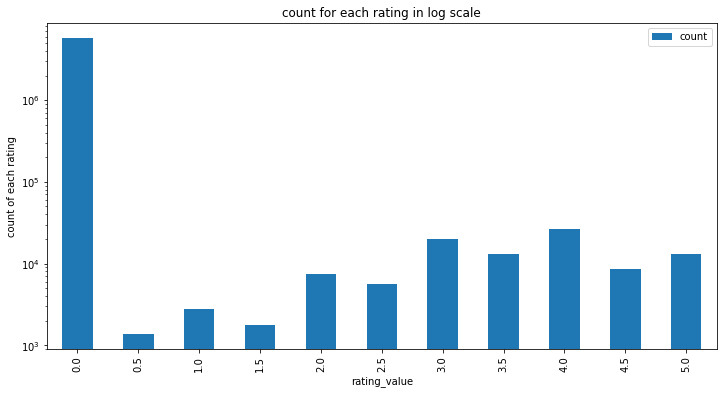

In [0]:
# plot a bar plot to visualise the ratings
rating_cnt_for_vis = rating_cnt
ax = rating_cnt_for_vis.reset_index().rename(columns = {'index':'rating_value'}).plot(
    x='rating_value',
    y='count',
    logy = True,
    kind='bar',
    title='count for each rating in log scale',
    figsize=(12,6)
)
ax.set_xlabel('rating_value')
ax.set_ylabel('count of each rating')
print("frequency of rating like 3 and 4 are more in compare to other ratings")

In [0]:
# 2) plot rating frequency of each movie(how many time a movie has been rated)

movie_freq = pd.DataFrame(ratings.groupby('movieId').size(),columns=['count'])
movie_freq.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'rating freq of movies')

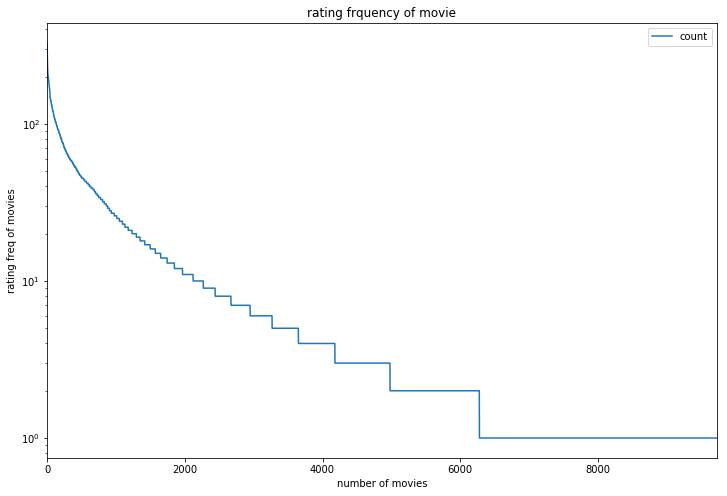

In [0]:
# plot movie rating freq
movie_freq_copy = movie_freq.sort_values(by='count',ascending=False)
movie_freq_copy=movie_freq_copy.reset_index(drop=True)

ax1  = movie_freq_copy.plot(
    title='rating frquency of movie',
    logy=True,
    figsize=(12,8)
)
ax1.set_xlabel('number of movies')
ax1.set_ylabel('rating freq of movies')

In [0]:
# we can see that most of the movies are rated very rarely ..
# so we can remove those movies which are rated less than 50 times.

threshold_rating_freq = 10
# first take out the movie id  for which movie is rated more than threshold value than keep only this movies in our original ratings dataframe
# movie_freq.query('count>= @threshold_rating_freq').shape = (13360,1)
# our original movie_freq has shape of (9724 ,1) and now its reduce to (2269,1)
# so now lets reduce the size of ratings dataframe

popular_movies_id = list(set(movie_freq.query('count>=@threshold_rating_freq').index))

# ratings df after dropping non popular movies
ratings_with_popular_movies = ratings[ratings.movieId.isin(popular_movies_id)]

print('shape of ratings:')
print(ratings.shape)

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print("no of movies which are rated more than 50 times:")
print(len(popular_movies_id))


print("no of unique movies present in dataset:")
print(unique_movie)

shape of ratings:
(100836, 4)
shape of ratings_with_popular_movies:
(81116, 4)
no of movies which are rated more than 50 times:
2269
no of unique movies present in dataset:
9724


Do similar analysis with user


In [0]:
user_cnt = pd.DataFrame(ratings.groupby('userId').size(),columns=['count'])
user_cnt_copy = user_cnt
user_cnt.head()

,count
userId,
1,232
2,29
3,39
4,216
5,44


Text(0, 0.5, 'rating frequency')

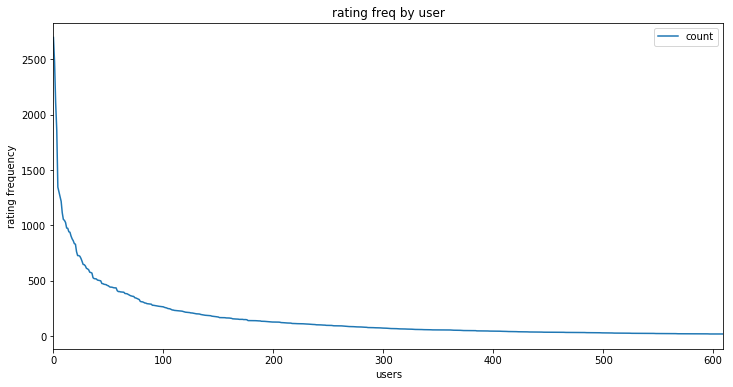

In [0]:
# plot rating freq
ax  = user_cnt_copy.sort_values('count',ascending=False).reset_index(drop=True).plot(
      title='rating freq by user',
      figsize=(12,6),
      
)
ax.set_xlabel("users")
ax.set_ylabel("rating frequency")

In [0]:
# you cans see tha rating frequency vs users characterstics is tail - like structure which is similar to previous plot.
# generally there are just few user who are interseted in giving rating to movies
# lets find the user who gives rating more than 30 times
threshold_val = 30
active_user = list(set(user_cnt.query('count>=@threshold_val').index))

#upadte your ratings_with_popular_movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.userId.isin(active_user)]

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print('shape of ratings_with_popular_movies_with_active_user:')
print(ratings_with_popular_movies_with_active_user.shape)

print("unique_user:")
print(unique_user)

print("active_user")
print(len(active_user))

print("unique_movies")
print(unique_movie)

print("popular_movies")
print(len(popular_movies_id))

shape of ratings_with_popular_movies:
(81116, 4)
shape of ratings_with_popular_movies_with_active_user:
(78712, 4)
unique_user:
610
active_user
501
unique_movies
9724
popular_movies
2269


shape of ratings_with_popular_movies:
(81116, 4)
shape of ratings_with_popular_movies_with_active_user:
(78712, 4)
unique_user:
610
active_user
501
unique_movies
9724
popular_movies
2269

So you can see that we have reduce significant number of user and movies in our dataset but shape of rating dataset doesnt change in that order because we are cosidering only movies that are rated more than threshold and user that do give ratings more than threshold value.
this is necessary due to following reasono:
1) it reduces the sparsity.
2) as we are going to use KNN algorithm for recommendation ,we are going to affected by "curse of dimensionality".
   KNN doesnt work properly in case of large nunber of dimension.
3) 

In [0]:
print("sparsity of final ratings df:")
print( (428*2269 - 76395)/(428*2269) )


sparsity of final ratings df:
0.9213340719902134


Sparsity in previous ratings dataframe: = .9830003169443864 sparsity in modified ratings dataframe: = 0.9213340719902134

so it is cleared that we have reduced the sparsity by removing non popular movies and non active user.

# building the KNN model
here we are going to use an unsupervised learning algorithm known as NearestNeibhours. so we have to reshape/prepare our dataset into a format which can be given as parameter. we will pivot our final dataset into a ITEM-USER matrix and empty cell with 0.( because KNN model calculates distance between two points. )

In [0]:
final_ratings = ratings_with_popular_movies_with_active_user
#final_ratings.shape
item_user_mat = final_ratings.pivot(index='movieId',columns = 'userId',values='rating').fillna(0)

In [0]:
# create a mapper which maps movie index and its title
movie_to_index = {
    movie:i for i,movie in enumerate(list(movies.set_index('movieId').loc[item_user_mat.index].title))
}
#(movie_to_index)

In [0]:
# create a sparse matrix for more efficient calculations
from scipy.sparse import csr_matrix
item_user_mat_sparse = csr_matrix(item_user_mat.values)

now when a movie name is given as input we need to find that any such movie present in our dataset or not.If it is not present
then we cant recommend anything .
so for string matching we are going to use fuzzy matching , based on result of fuzzy matching , a list of recommedation will be generated. lets create a function which take parameters (input_string , mapper=movie_to_index) .
This fucntion will return movie_id of movie title which is best match with input string .
It also prints the all matches .

In [0]:
pip install fuzzywuzzy


In [0]:
# fuzzy_movie_name_matching
from fuzzywuzzy import fuzz

def fuzzy_movie_name_matching (input_str,mapper,print_matches):
    # match_movie is list of tuple of 3 values(movie_name,index,fuzz_ratio)
    match_movie = []
    for movie,ind in mapper.items():
        current_ratio = fuzz.ratio(movie.lower(),input_str.lower())
        if(current_ratio>=50):
            match_movie.append((movie,ind,current_ratio))
     
    # sort the match_movie with respect to ratio 

    match_movie = sorted(match_movie,key =lambda x:x[2])[::-1]
    
    if len(match_movie)==0:
        print("Oops..! no such movie is present here\n")
        return -1
    if print_matches == True:
        print("some matching of input_str are\n")
        for title,ind,ratio in match_movie:
            print(title,ind,'\n')
     
        
    return match_movie[0][1]    
     
   

In [0]:
# define the model
from sklearn.neighbors import NearestNeighbors
recommendation_model = NearestNeighbors(metric='cosine',algorithm = 'brute',n_neighbors=20,n_jobs=-1)

In [0]:
# create a function which takes a movie name and make recommedation for it
def make_recommendation(input_str,data,model,mapper,n_recommendation):
    print("system is working....\n")
    model.fit(data)
    
    index = fuzzy_movie_name_matching (input_str,mapper,print_matches = False)
    
    if index==-1 :
        print("pls enter a valid movie name\n")
        return 
    
    index_list = model.kneighbors(data[index],n_neighbors=n_recommendation+1,return_distance=False)
    # now we ind of all recommendation
    # build mapper index->title
    index_to_movie={
        ind:movie for movie,ind in mapper.items()
    }
    
    print("Viewer who watches this movie ",input_str,"also watches following movies.")
    #print(index_list[0][2])
    for i in range(1,index_list.shape[1]):
        print(index_to_movie[index_list[0][i]])
    
    
    
    return 
    
    

In [0]:
make_recommendation('Father of the Bride Part II ',item_user_mat_sparse,recommendation_model,movie_to_index,10)

system is working....

Viewer who watches this movie  Father of the Bride Part II  also watches following movies.
Sabrina (1995)
Miracle on 34th Street (1994)
Striptease (1996)
Juror, The (1996)
Mr. Holland's Opus (1995)
Sgt. Bilko (1996)
Twister (1996)
Grumpier Old Men (1995)
Tin Cup (1996)
Willy Wonka & the Chocolate Factory (1971)


# important observations
1. Our model recommends movie which are almost release in similar years.
2. if you calculate cosine distance between input movie and recommends movie,
   this distance is very small due large number of cell in movie_user_mat is
   filled with 0. We have almost 92% sparsity in our final item_user_mat.
3. Since we have removed unpopular movies from our dataset , this movie will never be        recommend to user



# Some problem


1.   Cold Start Problem
     [link text](https://www.yuspify.com/blog/cold-start-problem-recommender-systems/)
2.   popular bias -->
     This model inly recommend those movies which are tagged as popluar movies.If look at movie rating frequency curve , tailender movies are removed. 

